In [1]:
%load_ext watermark
import numpy as np
import pandas as pd
import matplotlib as mpl
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import beta
from scipy.stats import multinomial


import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from myst_nb import glue
from slugify import slugify

from typing import List 

import plastockconf as psc
import plastock as pstk

from plastockconf import name_zones, name_frequentation, name_situation
from plastockconf import name_substrate, name_distance, table_css_styles, table_css_styles_top

from plastock import add_table_to_page, capitalize_x_tick_labels, capitalize_x_and_y_axis_labels, capitalize_legend_components, attribute_summary

import reportclass as rc

section = "PSM"
page = ""

def make_exportable(data, file_name, cmap='YlOrBr'):
    data.fillna(0, inplace=True)
    fig, ax = plt.subplots(figsize=(12,8))
    sns.heatmap(data=data, vmin=0, vmax=1, cmap=cmap, annot=True, fmt='.2', annot_kws={'size':10}, ax=ax, cbar=False)
    plt.tight_layout()
    ax.tick_params(which='both', axis='both', bottom=False, left=False)
    plt.savefig(file_name, dpi=300)

    plt.close()

glue('blank_caption', " ", display=False)

In [2]:
work_data = work_data = pd.read_csv('data/end_pipe/macro_data_msquared.csv')
beach_data = pd.read_csv("data/end_pipe/pstock_beaches_current.csv")
codes = pd.read_csv('data/end_pipe/codes.csv').set_index('code')

# the feature columns of the survey data
beach_datax = pd.read_csv("data/end_pipe/asl_beaches.csv").set_index('Plage')

# the city name of the survey locations
# the city name of the survey locations
city_map = pd.read_csv('data/end_pipe/city_map.csv')
city_map.set_index('slug', inplace=True, drop=True)

# translation of common terms into french, german and english
language_maps = rc.language_maps()

In [3]:
# we need to change the names from plastock that are duplicates
# in the IQAASL data.
change_names = ['preverenges', 'tolochenaz', 'versoix', 'vidy', 'cully']

changeus = work_data[work_data.slug.isin(change_names)].copy()
donotchange = work_data[~work_data.slug.isin(change_names)].copy()

new_slug = {
    'cully': 'cully-p',
    'preverenges': 'preverenges-p',
    'tolochenaz': 'tolochenaz-p',
    'versoix':'versoix-p',
    'vidy': 'vidy-p'}

# they have the same name as locations in iqaasl
changeus['new_slug'] = changeus.slug.apply(lambda x: new_slug[x])
changeus['slug'] = changeus.new_slug
changeus.drop('new_slug', inplace=True, axis=1)

# the plastock data with the converted names
report_data = pd.concat([changeus, donotchange])

In [4]:


# adding and renaming columns according to reportclass requirements
# these values can be indexed on the IQAASL data
report_data['city'] = report_data.slug.apply(lambda x: city_map.loc[x])
report_data['groupname'] = report_data.code.apply(lambda x: codes.groupname.loc[x])
report_data['date'] = pd.to_datetime(report_data["date"])

# ! this test is no longer valid !
# the data in the annex is aggregated on the postition feature
# that feature is dropped here
# grouping on substrate should produce the same values as table A4-1 
test = work_data.groupby(['échantillon', 'substrat'], as_index=False)['pcs/m²'].sum()
dtest = test.groupby('substrat')['pcs/m²'].describe()
dtest.index.name = None
dtest.rename(columns={'count':'compte', 'mean':'moyenne', 'std':'écart type'}, inplace=True)
dtest['compte'] = dtest.compte.astype(int)

caption = "Les valeurs doivent correspondre au table A4-1 dans l'annexe 'Macro déchets plage et attribut'"

dtest = dtest.style.set_table_styles(table_css_styles).format(precision=2).set_caption(caption).format(**psc.format_kwargs)

glue('dtest-sa', dtest, display=False)

In [5]:
def name_the_new_distance(x, less='<= 500 m', more = '> 500 m'):
    if x == 1:
        return less
    else:
        return more

def name_the_new_freq(x, new):
    if x <= 2:
        return new
    else:
        return 'Elévée'


# the feature variables are added to the work_data
ti = work_data.copy()
features = ['frequentation', 'situation', 'orientation', 'distance']

# they can be merged on the Plage column and the index
env_plastock = ti.merge(beach_datax[features], left_on='Plage', right_index=True)

# ! creation of composite variables !
t_and_f = env_plastock.loc[:, ['échantillon', 'slug','date','code', 'pcs/m²', 'quantité', 'frequentation', 'situation', 'distance', 'substrat', 'region']].copy()

# the substrat and distance features are being combined
# the two lowest and the two highest of each group are being combined
# substrat is a matter of combining different granularities. They are being grouped as
# sand and gravel.
# distance is now grouped by locations either less than or equal to 500 meters
t_and_f.loc[t_and_f.substrat <= 2, 'substrat'] = 1
t_and_f.loc[t_and_f.substrat > 2, 'substrat'] = 2
t_and_f.loc[t_and_f.distance <= 2, 'distance'] = 1
t_and_f.loc[t_and_f.distance > 2, 'distance'] = 2
t_and_f.loc[t_and_f.frequentation <= 2, 'frequentation'] = 2

# ! the data used in the models !
f_combi = t_and_f.copy()

f_combi.rename(columns={'frequentation':'fréquentation', 'loc_date': 'échantillon'}, inplace=True)

# the feature variables are combined along the ordinal axis. Going from four catgories
# to two in the case of distance and substrate. city and country are already binary
# the values of low and moderate frequentation are combined also.
f_comb = f_combi.copy()
f_comb['distance'] = f_comb['distance'].apply(lambda x: name_the_new_distance(x))
f_comb['fréquentation'] = f_comb['fréquentation'].apply(lambda x: name_the_new_freq(x, 'faible-moyenne'))
f_comb['situation'] = f_comb['situation'].apply(lambda x: name_situation[x])
f_comb['substrat'] = f_comb['substrat'].apply(lambda x: name_the_new_distance(x, less='Sable', more='Graviers'))

# ! no composite variables !
no_combined = env_plastock.loc[:, ['échantillon', 'slug','date','code', 'pcs/m²', 'frequentation', 'situation', 'distance', 'substrat', 'region']].copy()
no_combined.rename(columns={'frequentation':'fréquentation', 'loc_date': 'échantillon'}, inplace=True)

no_combined['distance'] = no_combined['distance'].apply(lambda x: name_distance[x])
no_combined['fréquentation'] = no_combined['fréquentation'].apply(lambda x: name_frequentation[x])
no_combined['situation'] = no_combined['situation'].apply(lambda x: name_situation[x])
no_combined['substrat'] = no_combined['substrat'].apply(lambda x: name_substrate[x])

In [6]:
fig, axs = plt.subplots(2, 2, figsize=(8,8))
wk_dt = report_data.groupby(['échantillon', 'date'], as_index=False)['pcs/m²'].sum()
wk_dt["date"] = pd.to_datetime(wk_dt["date"])
vals = 'pcs/m²'
object_column = vals
ylim = 4
xlim = 4
sns.scatterplot(wk_dt, x="date", y=vals, label='Plastock 2022 m²', ax=axs[0, 0])
sns.boxplot(wk_dt, y=vals,  showfliers=True, ax=axs[0, 1], dodge=False)
sns.histplot(wk_dt, x=vals,  ax=axs[1, 0], stat='probability', kde=True)
sns.ecdfplot(wk_dt, x=vals,  ax=axs[1, 1])

axs[0,0].xaxis.set_major_locator(mdates.MonthLocator(interval=3))
axs[0,0].xaxis.set_major_formatter(mdates.DateFormatter('%m-%y'))

axs[0, 0].set_ylim(-.01, ylim)
axs[0, 1].set_ylim(-.01, ylim)
axs[1, 1].set_xlim(-.01, xlim)
axs[1, 0].set_xlim(-.01, xlim)

axs[0, 0].set_xlabel("date")
axs[0, 0].set_ylabel(object_column)

axs[1, 0].set_xlabel(object_column)
axs[1, 0].set_ylabel("Probabilité")
axs[0, 1].set_xlabel("")
axs[0, 1].set_ylabel(object_column)
axs[0, 1].tick_params(axis="x", rotation=45)

axs[1, 1].set_xlabel(object_column)
axs[0,0].set_title("Total par échantillon", loc="left")
axs[0,1].set_title("Boîte de Tukey", loc="left")
axs[1,0].set_title("Histogramme", loc="left")
axs[1,1].set_title("Fonction de répartition", loc="left")
plt.subplots_adjust(wspace=.3)


plt.tight_layout()

glue('situataion-sa', fig, display=False)
plt.close()

In [7]:
situation_summary = rc.a_summary_of_one_vector(report_data, ['échantillon', 'date'], {'pcs/m²':'sum', 'quantité':'sum'}, describe  ='pcs/m²', total_column='quantité')
situation_summary.rename(columns={'pcs/m²':'résultats'}, inplace=True)
sit_disp = rc.translated_and_style_for_display(situation_summary, language_maps['fr'], 'fr', gradient=False)

caption = ""
sit_disp = add_table_to_page(sit_disp, 1, caption, section, page, "", format_index=None)
glue('sit_display', sit_disp, display=False)

/home/roger/dev/plastock/reportclass.py:362: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  d.applymap(lambda x: 'color: #E5E5E5' if pd.isnull(x) else '')
/home/roger/dev/plastock/reportclass.py:363: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  d.applymap(lambda x: 'background: #E5E5E5' if pd.isnull(x) else '')


In [8]:
# most common

quantity_code = work_data.groupby('code')['quantité'].sum()
pcsm_code = work_data.groupby('code')['pcs/m²'].mean()
percent_total = quantity_code/quantity_code.sum()

# fail_rate
work_data['gzero'] = work_data['quantité'] > 0
fail_rate = work_data.groupby('code').gzero.sum()
fail_rate = fail_rate/work_data['échantillon'].nunique()
inventory = pd.DataFrame({'Quantité':quantity_code, '% du total':percent_total, 'pcs/m²':pcsm_code, 'Taux d\'échec':fail_rate})
abundant_codes = inventory.sort_values(by='Quantité', ascending=False)[:10].index
frequent_codes = inventory[inventory['Taux d\'échec'] >= 0.5].index
most_common_codes = list(set([*frequent_codes, *abundant_codes]))

most_common_codes_df = inventory.loc[most_common_codes].sort_values(by='Quantité', ascending=False)
most_common_codes_df['index'] = most_common_codes_df.index.map(lambda x: codes.fr.loc[x])

mcm = most_common_codes_df.set_index('index', drop=True)
mcm.index.name = None
mc = mcm.style.set_table_styles(table_css_styles).format(**psc.format_kwargs)

caption = "les objets les plus courants de Plastock 2022."
mc = add_table_to_page(mc, 2, caption, section, page, "", format_index=None)

glue('mcm-sa', mc, display=False)

In [9]:
w_df = report_data.copy()
cities = w_df.city.unique()
cities.sort()
cone = cities[:12]
ctwo = cities[12:]



sample_id = "échantillon"
group_agg = {"quantité":"sum", "pcs/m²":"mean"}
unit_agg = {"quantité":"sum", "pcs/m²":"sum"}
pivot_values = vals

args = dict(
    feature_name='city', 
    object_column='code',
    sample_id=sample_id, 
    group_agg=group_agg, 
    unit_agg=unit_agg, 
    pivot_values=vals, 
    table_split=cone
)

t = rc.a_cumulative_report(w_df[(w_df.code.isin(most_common_codes))], **args)

mc_c1 = rc.translated_and_style_for_display(t, language_maps['fr'], 'fr',  gradient=True)
caption = "Les résultats des objets les plus courants en pcs/m² pour chaque ville du projet: Amphion à Hermance"

caption = "les objets les plus courants de Plastock 2022."
mc_c1 = add_table_to_page(mc_c1, 5, caption, section, page, "", format_index=None)
glue('most_common_c1', mc_c1, display=False)

/home/roger/dev/plastock/reportclass.py:361: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  d = d.applymap(color_gradient, cmap=conf_.newcmp)
/home/roger/dev/plastock/reportclass.py:362: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  d.applymap(lambda x: 'color: #E5E5E5' if pd.isnull(x) else '')
/home/roger/dev/plastock/reportclass.py:363: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  d.applymap(lambda x: 'background: #E5E5E5' if pd.isnull(x) else '')


In [10]:
file_name = 'resources/images/most_common_one-sa.jpg'
make_exportable(t, file_name)

In [11]:
args.update({'table_split':ctwo})
t = rc.a_cumulative_report(w_df[(w_df.code.isin(most_common_codes))], **args)

mc_c2 = rc.translated_and_style_for_display(t, language_maps['fr'], 'fr',  gradient=True)

caption = "Les résultats des objets les plus courants en pcs/m² pour chaque ville du projet: Lugrin à Vidy"

mc_c2 = add_table_to_page(mc_c2, 6, caption, section, page, "", format_index=None)
glue('most_common_c2', mc_c2, display=False)

/home/roger/dev/plastock/reportclass.py:361: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  d = d.applymap(color_gradient, cmap=conf_.newcmp)
/home/roger/dev/plastock/reportclass.py:362: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  d.applymap(lambda x: 'color: #E5E5E5' if pd.isnull(x) else '')
/home/roger/dev/plastock/reportclass.py:363: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  d.applymap(lambda x: 'background: #E5E5E5' if pd.isnull(x) else '')


In [12]:
file_name = 'resources/images/most_common_two-sa.jpg'
make_exportable(t, file_name)

In [13]:
w_df = report_data.copy()

args = dict(
    feature_name='city', 
    object_column='groupname', 
    sample_id=sample_id, 
    group_agg=group_agg, 
    unit_agg=unit_agg, 
    pivot_values=vals, 
    table_split=cone
)

groups_df = report_data.copy()
group_name_map = codes['groupname']
groups_df['groupname'] = groups_df.code.apply(lambda x: group_name_map.loc[x])
tg1 = rc.a_cumulative_report(groups_df, feature_name='city', object_column='groupname', sample_id=sample_id, group_agg=group_agg, unit_agg=unit_agg, pivot_values=vals, table_split=cone)

gn_c1 = rc.translated_and_style_for_display(tg1, language_maps['fr'], 'fr', gradient=True)

caption ="Les résultats des objets par utilisation pour chaque ville du projet: Amphion à Hemance"

gn_c1 = add_table_to_page(gn_c1, 7, caption, section, page, "", format_index=None)
glue('gn_c1', gn_c1, display=False)

/home/roger/dev/plastock/reportclass.py:361: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  d = d.applymap(color_gradient, cmap=conf_.newcmp)
/home/roger/dev/plastock/reportclass.py:362: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  d.applymap(lambda x: 'color: #E5E5E5' if pd.isnull(x) else '')
/home/roger/dev/plastock/reportclass.py:363: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  d.applymap(lambda x: 'background: #E5E5E5' if pd.isnull(x) else '')


In [14]:
file_name = 'resources/images/group_names_one-sa.jpg'
make_exportable(tg1, file_name)

In [15]:
args.update({'table_split':ctwo})

tg2 = rc.a_cumulative_report(groups_df, **args)
gn_c2 = rc.translated_and_style_for_display(tg2, language_maps['fr'], 'fr', gradient=True)

caption ="Les résultats des objets par utilisation pour chaque ville du projet: Lugrin à Vidy"
gn_c2 = add_table_to_page(gn_c2, 8, caption, section, page, "", format_index=None)

glue('gn_c2', gn_c2, display=False)

/home/roger/dev/plastock/reportclass.py:361: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  d = d.applymap(color_gradient, cmap=conf_.newcmp)
/home/roger/dev/plastock/reportclass.py:362: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  d.applymap(lambda x: 'color: #E5E5E5' if pd.isnull(x) else '')
/home/roger/dev/plastock/reportclass.py:363: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  d.applymap(lambda x: 'background: #E5E5E5' if pd.isnull(x) else '')


In [16]:
file_name = 'resources/images/group_names_two-sa.jpg'
make_exportable(tg2, file_name)

In [17]:
unit_columns = ['region', 'échantillon']
rg = []
label='Haut lac'
summary_index = ['min', '25%', '50%', '75%', 'max', 'mean', 'std', 'count', 'total']
for label in report_data.region.unique():
    g = rc.a_summary_of_one_vector(report_data[report_data.region == label].copy(), unit_columns=unit_columns, unit_agg=unit_agg, describe='pcs/m²', label=label, total_column='quantité')
    rg.append(g)
regional_summary = pd.concat(rg)
rg = regional_summary.pivot(columns='label', values='pcs/m²')
rg = rg.reindex(summary_index)

rcg = rc.translated_and_style_for_display(rg, language_maps['fr'], 'fr', gradient=False)

rcg_hist = rcg.highlight_max(axis=1, props= 'color: rgba(255, 0, 0, 1);')

caption = ""
rcg_hist = add_table_to_page(rcg_hist, 3, caption, section, page, "", format_index=None)
glue('regional_summary_sa', rcg_hist, display=False)

/home/roger/dev/plastock/reportclass.py:362: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  d.applymap(lambda x: 'color: #E5E5E5' if pd.isnull(x) else '')
/home/roger/dev/plastock/reportclass.py:363: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  d.applymap(lambda x: 'background: #E5E5E5' if pd.isnull(x) else '')


In [18]:
mc_reg = report_data.groupby(['region', 'échantillon', 'code'], as_index=False)['pcs/m²'].sum()
mcg = mc_reg[mc_reg.code.isin(most_common_codes)].groupby(["region", "code"], as_index=False)["pcs/m²"].mean()
mcg = mcg[['region', 'code', 'pcs/m²']].pivot(index='code', values='pcs/m²', columns='region')


mcg = rc.translated_and_style_for_display(mcg, language_maps['fr'], 'fr', gradient=False) 

caption = "La moyenne des objets les plus courants par région. Plastock 2022"
mcg_hist = mcg.highlight_max(axis=1, props= 'color: rgba(255, 0, 0, 1);').set_caption(caption)
mcg_hist  = add_table_to_page(mcg_hist, 4, caption, section, page, "", format_index=None)
glue('regional_most_common', mcg_hist, display=False)

/home/roger/dev/plastock/reportclass.py:362: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  d.applymap(lambda x: 'color: #E5E5E5' if pd.isnull(x) else '')
/home/roger/dev/plastock/reportclass.py:363: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  d.applymap(lambda x: 'background: #E5E5E5' if pd.isnull(x) else '')


In [19]:
distance_index = ['<= 500 m', '> 500 m']
freq_index = ['Elévée', 'faible-moyenne']
sub_index =  ['Graviers', 'Sable']

# Calculate stats for each category with combined rows
frequentation_stats = pstk.calculate_combined_stats('fréquentation', data=f_comb.copy(), val_column='pcs/m²', index=freq_index)
situation_stats = pstk.calculate_combined_stats('situation', data=f_comb.copy(), val_column='pcs/m²')
distance_stats = pstk.calculate_combined_stats('distance', data=f_comb.copy(), index=distance_index, val_column='pcs/m²')
substrat_stats = pstk.calculate_combined_stats('substrat', data=f_comb.copy(), index=sub_index, val_column='pcs/m²')

freq_stats = add_table_to_page(frequentation_stats, 9, "densité de déchets par fréquentation", section, page, "", format_index=None)
sit_stats = add_table_to_page(situation_stats, 10, "densité de déchets par urbanization", section, page, "", format_index=None)
dist_stats = add_table_to_page(distance_stats, 11, "densité de déchets par distance de parking", section, page, " ", format_index=None)
sub_stats = add_table_to_page(substrat_stats, 12, "densité de déchets selon substrat", section, page, "", format_index=None)

glue('freq_stats_sa', freq_stats, display=False)
glue('sit_stats_sa', sit_stats, display=False)
glue('dist_stats_sa', dist_stats, display=False)
glue('sub_stats_sa', sub_stats, display=False)

In [20]:
dt = work_data.groupby(['échantillon', 'Plage', 'region'], as_index=False)['pcs/m²'].sum()
dt = dt.groupby('Plage', as_index=False)['pcs/m²'].mean()
dtcigs = work_data[work_data.code == "G27"].groupby(['échantillon', 'Plage', 'region'], as_index=False)['pcs/m²'].sum()
dtcigs = dtcigs.groupby('Plage', as_index=False)['pcs/m²'].mean()
dtfrags = work_data[work_data.code == 'Gfrags'].groupby(['échantillon', 'Plage', 'region'], as_index=False)['pcs/m²'].sum()
dtfrags = dtfrags.groupby('Plage', as_index=False)['pcs/m²'].mean()
dtcigs["G27"] = dtcigs["pcs/m²"]
dtfrags["Gfrags"] = dtfrags["pcs/m²"]

dt['Total'] = dt['pcs/m²']

region_map = work_data[["Plage", "region"]].drop_duplicates(["Plage", "region"])
region_map.set_index("Plage", drop=True, inplace=True)

gps_map = beach_data[["Plage", "latitude", "longitude"]].drop_duplicates("Plage")
gps_map.set_index("Plage", drop=True, inplace=True)

gps = dt[["Plage", "Total"]].merge(dtcigs[["Plage", "G27"]],left_on=["Plage"], right_on=["Plage"])

gps = gps.merge(dtfrags[["Plage", "Gfrags"]], left_on=["Plage"], right_on=["Plage"])
gps["region"] = gps.Plage.apply(lambda x: region_map.loc[x])

gps["lat"] = gps.Plage.apply(lambda x: gps_map.loc[x, "latitude"])
gps["lon"] = gps.Plage.apply(lambda x: gps_map.loc[x, "longitude"])
gps.to_csv("resources/maps/plastock_mq.csv", index=False)

# Plastock Macros déchets 

Les déchets de plage ont été échantillonnés tous les trimestres du 1er janvier 2022 au 31 décembre 2022 sur les plages du lac Léman. Les participants ont mesuré la longueur le long de la ligne d'eau et la largeur, la distance de la ligne d'eau, de chaque site d'étude. Au cours de cette période de 12 mois, les volontaires ont collecté et identifié 27 493 objets sur 25 sites, représentant 24 villes du bassin Lémanique, ([résultats](sa_results)).


:::{card}
:margin: 3

```{image} resources/maps/chapter_two_map.jpg.jpeg
:alt: chapter two map
:align: center
:name: chapter_two_map
```
+++
<b>Fig 3.1 :</b> Carte des résultats de l'étude. Densité moyenne de déchets par site d'échantillonnage. Le diamètre du marqueur est relatif à la densité moyenne de déchets par mètre carré de plage.
:::

Le résultat moyen était de 0,66 déchets par mètre² (pcs/m²). L'objet le plus courant est le plastique fragmenté, qui représente 41 % du total des objets (0,26 pièce/m²), suivi des mégots de cigarettes, qui représentent 11 % du total (0,07 pièce/m²).  Les objets les plus courants, ([plus courants](mc_sa)), en 2022 avaient tous été identifiés lors de campagnes antérieures sur le lac. Il convient de noter que six des objets les plus courants identifiés dans les études Plastock sont également les plus courants dans la région OSPAR ([OSPAR correspondance](cor_ospar)). 

Les échantillons ont été prélevés des deux côtés du lac et dans les trois régions. Le plus grand nombre d'échantillons a été collecté dans le Grand lac (47), suivi du Petit lac (27) et enfin du Haut lac (24). Le résultat moyen était le plus élevé dans le Haut lac (0,95 pcs/m²), suivi par le Grand lac (0,65 pcs/m²) et enfin le Petit lac (0,4 pcs/m²). Tous les objets les plus courants, à l'exception des capsules de bouteilles, ont également enregistré des valeurs moyennes plus élevées dans le Haut Lac. Cependant, la valeur médiane est la plus élevée dans le Grand lac et la différence entre la médiane et la moyenne est la plus élevée dans le Haut lac ([régionalité](mc_regional)).

Les résultats de l'enquête sur les objets tels que les mégots de cigarettes et les emballages de snacks devraient être plus élevés dans les endroits où le substrat est sablonneux et où il y a un accès à un parking. Les sites éloignés ou constitués d'un substrat de gravier présentent des niveaux plus élevés de plastiques fragmentés. Différents modèles ont été envisagés à l'aide d'une régression par forêt aléatoire ([random forest](random_forest_sa))  et d'une approximation par grille ([grid approximation](grid_approx_p)).

__Autres campganes :__

Le Swiss Litter Report ([Swiss Litter Report](http://www.stoppp.org/)) fait état d'une moyenne de 0,67 déchet par m². La moyenne déclarée pour les lacs était de 1,23 pcs/m², avec des chiffres élevés dans les zones urbaines de 1,03 pcs/m². Nous notons que ces valeurs se situent dans la fourchette que l'on pourrait attendre de la mer ionienne (0,67 pcs/m²) ([Ionian](ionian)) ou de la mer méditerranée (0,61 pcs/m²)([Mediterranean](mediteranean)).

__Perspectives 2024 :__

Si nous utilisons la même logique que celle appliquée dans ([résulats précédents](previous_results)), le résultat médian estimé pour 2024 se situe entre 0,43 pcs/m² et 0,62 pcs/m². Les sites avec un substrat de gravier ou plus éloignés auront des valeurs de comptage plus faibles pour les mégots de cigarettes et les emballages de snacks, mais des proportions plus élevées de plastiques fragmentés.

(sa_results)=
## Résultats
::::{grid} 1 1 2 2

:::{grid-item}

{glue}`sit_display`

:::

:::{grid-item}
L’échantillonnage était planifié trimestriellement, commençant en janvier 2022. À quelques exceptions près, chaque emplacement était échantillonné quatre fois au cours de la période de 12 mois.

Au total, 98 échantillons ont été enregistrés sur 25 sites représentant 24 villes sur les rives du Léman.

<b>Table PSM-1 :</b> Distribution des résultats de l’ensemble de l’échantillons Plastock.
:::

::::

:::{card} 

```{glue} situataion-sa
```
+++
<b> Figure 3.2 :</b> Plastock 2022, distribution des résultats de l’ensemble des échantillons.
:::


(mc_sa)=
### Les objets les plus courants 

#### Définition des _objets les plus courants_

Les _objets les plus courants_ peuvent être sélectionnés de plusieurs manières. On peut également les appeler les _objets d'intérêt_. Dans le cadre de ce rapport, nous nous concentrons sur les objets qui représentent une proportion plus importante des résultats que les autres. Nous avons utilisé deux critères de sélection : i. la quantité, ii. le taux d'échec.

1. Quanité: Si un objet a une quantité totale qui le place dans les dix premiers, il est considéré comme _courant_.
2. Taux d'échec: Si un objet a été trouvé dans au moins la moitié des échantillons, il est ÉGALEMENT considéré comme _courant_.

Par conséquent, pour cette étude, les 'objets les plus courants' sont ceux qui se trouvent soit dans les dix premiers en termes de nombre total de pièces de déchets ET/OU qui ont été trouvés dans au moins 50% des enquêtes. Pour Plastock, les objets les plus courants représentent 89% du montant total ou 24'156/27'493.

{glue}`mcm-sa`

(mc_regional)=
#### Les plus courants par région


::::{grid} 1 1 2 2
:::{grid-item}
{glue}`regional_summary_sa`
:::

:::{grid-item}
:padding: 4 1 1 1
Comme nous l'avons vu précédemment, le Haut Lac a en moyenne des valeurs plus élevées que les deux autres régions. Cependant, nous remarquons que les valeurs minimales et de 25 % sont plus faibles dans le Haut Lac et que la médiane est presque la même que dans le Grand Lac. Cela suggère que les événements extrêmes sont plus probables dans le Haut Lac que dans le Grand Lac. Carte des régions [régions](leman_regions).

<br />

<b>Table PSM-3 :</b> Plastock 2022, distribution des résultats par échantillon et par région.
:::

:::{grid-item}
:columns: 12

{glue}`regional_most_common`

:::
::::

#### Les plus courants par ville

__Amphion à Hermance__

```{glue} most_common_c1
```
<br>

__Lugrin à Vidy__

```{glue} most_common_c2
``` 

### Les objets trouvés en fonction de leur utilisation

Le type d'utilité est basé sur l'utilisation de l'objet avant qu'il ne soit jeté ou sur la description de l'objet si l'utilisation initiale est indéterminée. Les objets identifiés sont classés dans l'une des 260 catégories prédéfinies. Les catégories sont regroupées en fonction de leur utilisation ou de leur description.

- Eaux usées : objets rejetés par les stations d'épuration, y compris les objets susceptibles d'être jetés dans les toilettes.
- Microplastiques (< 5 mm) : plastiques fragmentés et résines plastiques de préproduction.
- Infrastructure : objets liés à la construction et à l'entretien des bâtiments, des routes et des réseaux d'eau et d'électricité.
- Alimentation et boisson : tous les matériaux liés à la consommation de nourriture et de boissons.
- Agriculture : principalement des feuilles industrielles, par exemple, paillis et bâches de culture, serres, fumigation du sol, films d'emballage de balles. Comprend les plastiques durs pour les clôtures agricoles, les pots de fleurs, etc.
- Tabac : principalement des filtres de cigarettes, y compris tous les matériaux liés au tabagisme.
- Loisirs : objets liés au sport et aux loisirs, par exemple, pêche, chasse, randonnée, etc.
- Emballages non alimentaires et non liés au tabac : matériaux d'emballage non identifiés comme étant liés à la nourriture, aux boissons ou au tabac.
- Fragments de plastique : morceaux de plastique d'origine ou d'utilisation indéterminée.
- Objets personnels : accessoires, articles d'hygiène et vêtements.

Pour des informations détaillées sur la composition des groupes, consultez ([IQAASL - DE](https://hammerdirt-analyst.github.io/IQAASL-End-0f-Sampling-2021/code_groups.html)) ou ([IQAASL - EN](https://www.plagespropres.ch/code_groups.html)).
<br>

__Amphion à Hermance__

```{glue} gn_c1
```
<br>

__Lugrin à Vidy__

```{glue} gn_c2
``` 
<br>

### Conditions d’échantillonnage

Les enquêteurs ont classé les conditions à chaque emplacement d’échantillonnage selon quatre catégories, fréquentation, substrat, distance au parking et situation (ville/campagne). Les plages ayant un taux d’utilisation élevé représentaient 56% (55/98) de tous les échantillons. Les plages situés à moins de 500 mètres d’un parking représentent 84% (83/98). Le résumé en détail est disponible ([attributes](macro-attributes)).

Les catégories ont été combinées afin de réduire la covariance et d'améliorer l'interprétabilité. Les catégories ont été réduites de 4 à 2 dans le cas du substrat et de la distance au parking. La fréquence a été réduite à deux groupes en combinant les deux rangs les plus bas. Vous pouvez consulter les détails de la raison et de la manière dont nous procédons ici ([correlations](correlations)). Les résultats sont présentés ci-dessous :

::::{grid} 1 1 2 2 

:::{grid-item}

{glue}`freq_stats_sa`

:::

:::{grid-item}

{glue}`dist_stats_sa`

:::

:::{grid-item}

{glue}`sub_stats_sa`

:::

:::{grid-item}

{glue}`sit_stats_sa` 

:::

::::

Les lieux avec une plage de sable avaient la valeur médiane la plus élevée, soit .52 pcs/m² v/s graviers 0.24 pcs/m². Les lieux classés comme urbains avaient une valeur médiane de 0,52 pcs/m² pour 31 échantillons, contre 0,38 pcs/m² a la campagne pour 67 échantillons. Mais, l’échantillon moyenne attendu est plus élevé dans les localités désignées comme étant à la campagne (0.71 contre 0.57). Á la campagne, on s’attend à trouver plus de Gfrags et de pellets industriels (GPI) en % du total. Dans les villes, nous nous attendons à trouver plus de bouts de cigarettes et d’emballages de snacks par échantillon. Des prédictions ont été faites en utilisant différentes combinaisons de catégories à l’aide du régresseur de la forêt aléatoire ([Random forest](random_forest_sa)) et d’une approximation de la grille bayésienne ([Grid approximations](grid_approx_p)).




<!-- ### Exigences particulières données plastock

La quantité de déchets sauvages par mètre² de plage correspond au nombre total d'objets identifiés divisé par la surface d'étude. Pour les données Plastock, cela signifie que nous devons considérer la position un (ligne d'eau) et la position deux (plage sèche) ensemble. 


::::{grid}

:::{grid-item}
{glue}`dtest-sa`
:::

:::{grid-item}
:padding: 4 2 2 2
Les déchets par mètre carré sont considérés comme la somme de la surface de la position 1 et de la surface de la position 2 pour chaque échantillon [Macro déchets plage et attribut](macro-attributes).
:::
::::

De plus, il y a __douze échantillons où le substrat était différent entre la position un et la position deux__. Par conséquent, ces 12 échantillons ont tous été classés dans la catégorie Sables grossiers. La distribution de la variable de substrat après la réattribution des 12 échantillons en question : 1. Sables fins : 27%, 2. Sables Grossiers : 32%, 3. Graviers : 16%, 4. Cailloux : 25%. -->



## Estimation des paramètres et prédictions

In [21]:
cols = ['échantillon', 'fréquentation','situation', 'distance', 'substrat']

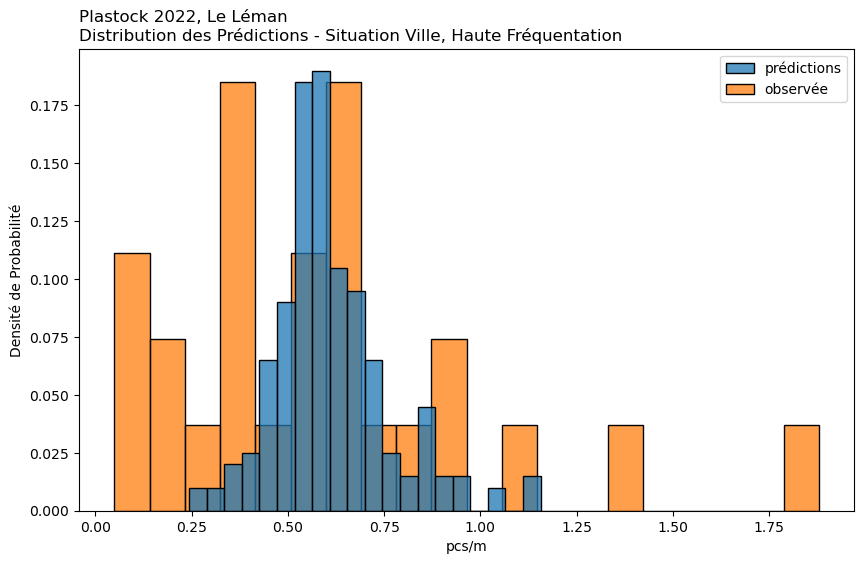

In [22]:
# Filter for Scenario 
test_xi = f_combi[(f_combi['situation'] == 2) & (f_combi['fréquentation'] == 3)].copy()
test_xi.rename(columns={'pcs/m²':'pcs_m'}, inplace=True)
test_x = test_xi.groupby(cols, as_index=False).pcs_m.sum()
test_x = test_x[['fréquentation', 'situation', 'distance', 'substrat', 'pcs_m']]

# model parameters
estimators = 10
iterations = 100

func = RandomForestRegressor(n_estimators=estimators, criterion="absolute_error", random_state=42, max_samples=.5)
predictions, feature_importance, mse, r2 = pstk.analyze_scenario(test_x, func,  n_iterations=iterations)

caption = 'Urban, Fréquentation Elévée'
q_sit_2_freq_3 = pstk.makeqdf(test_x.pcs_m.values, predictions, caption=caption)
glue('q-hf-ville-sa', q_sit_2_freq_3, display=False)

# the histogram for this scenario:
title = 'Plastock 2022, Le Léman\nDistribution des Prédictions - Situation Ville, Haute Fréquentation'
pstk.plot_histogram(predictions, test_x.pcs_m.values, title=title, reference='ville-hf-sa', display=True)

In [23]:
# Filter for Scenario 
test_xi = f_combi[(f_combi['situation'] == 1) & (f_combi['fréquentation'] == 3)].copy()
test_xi.rename(columns={'pcs/m²':'pcs_m'}, inplace=True)
test_x = test_xi.groupby(cols, as_index=False).pcs_m.sum()
test_x = test_x[['fréquentation', 'situation', 'distance', 'substrat', 'pcs_m']]

func = RandomForestRegressor(n_estimators=estimators, criterion="absolute_error", random_state=42, max_samples=.5)
predictions, feature_importance, mse, r2 = pstk.analyze_scenario(test_x, func,  n_iterations=iterations)

# the quantiles for this scenario
caption="Campagne, Fréquentation Eléveé"
q_sit_1_freq_3 = pstk.makeqdf(test_x.pcs_m.values, predictions, caption=caption)
glue('q-hf-camp-sa', q_sit_1_freq_3, display=False)

# the histogram for this scenario:
title = 'Plastock 2022, Le Léman\nDistribution des Prédictions - Situation Campagne, Haute Fréquentation\n'
pstk.plot_histogram(predictions, test_x.pcs_m.values, title=title, reference='camp-hf-sa', display=False)

In [24]:
# Filter for Scenario 
test_xi = f_combi[(f_combi['situation'] == 1) & (f_combi['distance'] == 1)].copy()
test_xi.rename(columns={'pcs/m²':'pcs_m'}, inplace=True)
test_x = test_xi.groupby(cols, as_index=False).pcs_m.sum()
test_x = test_x[['fréquentation', 'situation', 'distance', 'substrat', 'pcs_m']]


func = RandomForestRegressor(n_estimators=estimators, criterion="absolute_error", random_state=42, max_samples=.5)
predictions, feature_importance, mse, r2 = pstk.analyze_scenario(test_x, func,  n_iterations=iterations)

# the quantiles for this scenario
caption = 'Campagne, <= 500 m du parking'
q_sit_1_d_1 = pstk.makeqdf(test_x.pcs_m.values, predictions, caption=caption)
glue('q-camp-dist_1-sa', q_sit_1_d_1, display=False)

# the histogram for this scenario:
title = 'Plastock 2022, Le Léman\nDistribution des Prédictions - Situation Campagne, distance < 500 m'
pstk.plot_histogram(predictions, test_x.pcs_m.values, title=title, reference='camp-dist-1-sa', display=False)

In [25]:
# Filter for Scenario 
test_xi = f_combi[(f_combi['situation'] == 2) & (f_combi['distance'] == 1)].copy()
test_xi.rename(columns={'pcs/m²':'pcs_m'}, inplace=True)
test_x = test_xi.groupby(cols, as_index=False).pcs_m.sum()
test_x = test_x[['fréquentation', 'situation', 'distance', 'substrat', 'pcs_m']]

func = RandomForestRegressor(n_estimators=estimators, criterion="absolute_error", random_state=42, max_samples=.5)
predictions, feature_importance, mse, r2 = pstk.analyze_scenario(test_x, func,  n_iterations=iterations)

# the quantiles for this scenario
caption = 'Urban, <= 500 m du parking'
q_sit_2_d_1 = pstk.makeqdf(test_x.pcs_m.values, predictions, caption=caption)
glue('q-ville-dist_1-sa', q_sit_2_d_1, display=False)

# the histogram for this scenario:
title = 'Plastock 2022, Le Léman\nDistribution des Prédictions - Situation Ville, distance < 500 m'
pstk.plot_histogram(predictions, test_x.pcs_m.values, title=title, reference='ville-dist-1-sa', display=False)

In [26]:
# Filter for Scenario 
test_xi = f_combi[(f_combi['substrat'] == 1)].copy()
test_xi.rename(columns={'pcs/m²':'pcs_m'}, inplace=True)
test_x = test_xi.groupby(cols, as_index=False).pcs_m.sum()
test_x = test_x[['fréquentation', 'situation', 'distance', 'substrat', 'pcs_m']]
func = RandomForestRegressor(n_estimators=estimators, criterion="absolute_error", random_state=42, max_samples=.5)
predictions, feature_importance, mse, r2 = pstk.analyze_scenario(test_x, func,  n_iterations=iterations)

# the quantiles for this scenario
caption = 'Sables'
q_sub_1 = pstk.makeqdf(test_x.pcs_m.values, predictions, caption=caption)
glue('q_subs_1-sa', q_sub_1, display=False)

# the histogram for this scenario:
title = 'Plastock 2022, Le Léman\nDistribution des Prédictions - Sables'
pstk.plot_histogram(predictions, test_x.pcs_m.values, title=title, reference='subs_1_hist-sa', display=False)

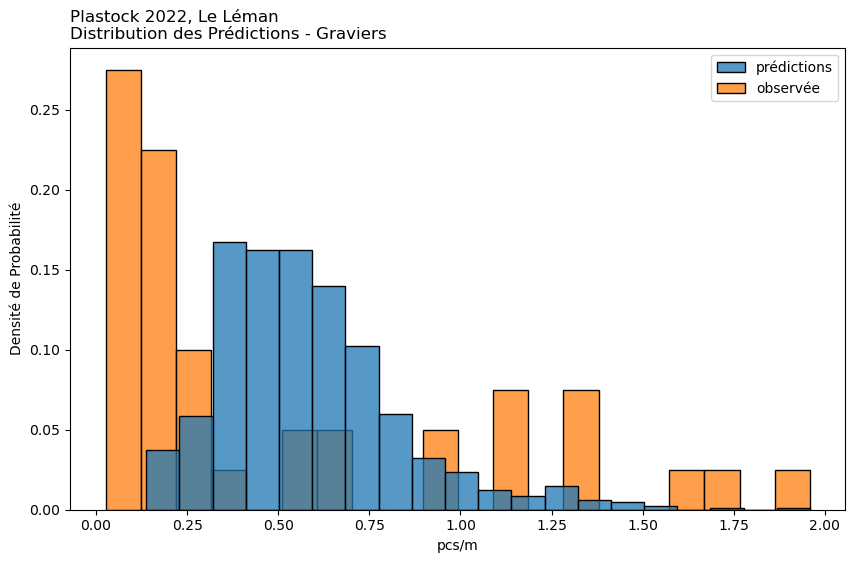

In [27]:
# Filter for Scenario 
test_xi = f_combi[(f_combi['substrat'] == 2)].copy()
test_xi.rename(columns={'pcs/m²':'pcs_m'}, inplace=True)
test_x = test_xi.groupby(cols, as_index=False).pcs_m.sum()
test_x = test_x[['fréquentation', 'situation', 'distance', 'substrat', 'pcs_m']]
func = RandomForestRegressor(n_estimators=estimators, criterion="absolute_error", random_state=42, max_samples=.5)
predictions, feature_importance, mse, r2 = pstk.analyze_scenario(test_x, func,  n_iterations=iterations)

# the quantiles for this scenario
caption='Graviers'
q_sub_2 = pstk.makeqdf(test_x.pcs_m.values, predictions, caption=caption)
glue('q_subs_2-sa', q_sub_2, display=False)

# the histogram for this scenario:
title = 'Plastock 2022, Le Léman\nDistribution des Prédictions - Graviers'
pstk.plot_histogram(predictions, test_x.pcs_m.values, title=title, reference='subs_2_hist-sa', display=True)

In [28]:
# Filter for Scenario 
# This is all the values => no filter
# just aggregating to the sample_id 
test_xi = f_combi.copy()
test_xi.rename(columns={'pcs/m²':'pcs_m'}, inplace=True)
test_x = test_xi.groupby(cols, as_index=False).pcs_m.sum()

func = RandomForestRegressor(n_estimators=estimators, criterion="absolute_error", random_state=42)
predictions, feature_importance, mse, r2 = pstk.analyze_scenario(test_x, func,  n_iterations=iterations)

# the quantiles for this scenario
caption = 'Toutes les conditions'
q_tous = pstk.makeqdf(test_x.pcs_m.values, predictions, caption=caption)
glue('q-tous-sa', q_tous, display=False)

# the histogram for this scenario:
title = 'Plastock 2022, Le Léman\nDistribution des Prédictions'
pstk.plot_histogram(predictions, test_x.pcs_m.values, title=title, reference='tous-sa', display=False)

(random_forest_sa)=
### Random Forest 

Source : [scikit-learn random forest](https://scikit-learn.org/0.16/modules/generated/sklearn.ensemble.RandomForestRegressor.html)

criterion : `absolute error`

La régression avec forêt aléatoire est une technique d'apprentissage automatique (machine learning) utilisée pour prédire des résultats continus (par opposition aux catégories dans la classification). C'est une méthode d'apprentissage ensembliste, ce qui signifie qu'elle combine les prédictions de plusieurs algorithmes d'apprentissage automatique pour produire des prédictions plus précises.

::::{tab-set}

:::{tab-item} Toutes les conditions
{glue}`tous-sa`
:::

:::{tab-item} Graviers
{glue}`subs_2_hist-sa`
:::

:::{tab-item} Sables
{glue}`subs_1_hist-sa`
:::

:::{tab-item} Ville et haute Fréquentation
{glue}`ville-hf-sa`
:::

:::{tab-item} Campagne et haute fréquentation
{glue}`camp-hf-sa`
:::

:::{tab-item} Campagne et parking <= 500 m
{glue}`camp-dist-1-sa`

:::

:::{tab-item} Ville et parking <= 500 m
{glue}`ville-dist-1-sa`

:::



:::{tab-item} Résultats
:selected:

````{grid} 1 2 2 2

```{grid-item}
{glue}`q-tous-sa`
```

```{grid-item}

Les modèles ont fait l'objet d'un bootstrap, 1000 itérations pour chaque scénario. Les résultats estimés sont la collection de toutes les prédictions de chaque itération.

Par exemple, le tableau intitulé "Gravier" présente les résultats observés et prévus pour les plages ayant un substrat de 3 ou 4.

```

```{grid-item}
{glue}`q_subs_2-sa`
```

```{grid-item}
{glue}`q_subs_1-sa`
```

```{grid-item}
{glue}`q-hf-ville-sa`
```

```{grid-item}
{glue}`q-hf-camp-sa`
```

```{grid-item}
{glue}`q-camp-dist_1-sa`
```

```{grid-item}
{glue}`q-ville-dist_1-sa`
```

````
:::

::::
    

In [29]:
# Grid approximation
grid_val_index = np.linspace(0, 5.99, 600)
groupby_columns = ['sample_id', 'location', 'date', 'city', 'orchards', 'vineyards', 'buildings', 'forest',
                   'undefined', 'public_services', 'streets']

In [30]:
col = 'top'
pcs_col = 'pcs/m²'
grid_range = grid_val_index
bins = [1]

beta_prior = pstk.calculate_beta_prior(grid_range=grid_range, bin_density_numbers=[1])

test_x = f_combi.copy().groupby(cols, as_index=False)[pcs_col].sum()
test_x['top'] = 1

grid_pstock = pstk.calculate_likelihood(aggregated_data=test_x, bin_density_column=col, pcs_column=pcs_col, grid_range=grid_range, bins=bins)

# posterior uninformed
post_grid_pstock = pstk.define_posterior(grid_pstock, beta_prior, grid_val_index=grid_range)

# samples
sample_totals = pstk.posterior_predictions(post_grid_pstock.copy())

caption = 'Toutes les conditions'

test_grid_quants = pstk.makeqdf(test_x[pcs_col].values, sample_totals, caption=caption)
glue('q-tous-b-sa', test_grid_quants, display=False)

title = 'Plastock 2022, Le Léman\nDistribution des Prédictions: toutes les conditions,  grid approximation, prior = IQAASL'

pstk.plot_histogram(sample_totals, test_x[pcs_col].values, title=title, reference='toutes-gapprox-sa', display=False)

In [31]:
col = 'substrat'
pcs_col = 'pcs/m²'
grid_range = grid_val_index
bins = [1]

test_xi = f_combi[(f_combi['substrat'] == 1)].copy()
test_x = test_xi.groupby(cols, as_index=False)[pcs_col].sum()


grid_pstock = pstk.calculate_likelihood(aggregated_data=test_x, bin_density_column=col, pcs_column=pcs_col, grid_range=grid_range, bins=bins)

# posterior uninformed
post_grid_pstock = pstk.define_posterior(grid_pstock, beta_prior, grid_val_index=grid_range)

# samples
sample_totals = pstk.posterior_predictions(post_grid_pstock.copy())

caption = 'Sable'

test_grid_quants = pstk.makeqdf(test_x[pcs_col].values, sample_totals, caption=caption)
glue('q-sable-b-sa', test_grid_quants, display=False)
title = 'Plastock 2022, Le Léman\nDistribution des Prédictions: Sable, grid approximation'

pstk.plot_histogram(sample_totals, test_x[pcs_col].values, title=title, reference='sables-gapprox-sa', display=False)

In [32]:
col = 'substrat'
pcs_col = 'pcs/m²'
grid_range = grid_val_index
bins = [2]

test_xi = f_combi[(f_combi['substrat'] == 2)].copy()
test_x = test_xi.groupby(cols, as_index=False)[pcs_col].sum()


grid_pstock = pstk.calculate_likelihood(aggregated_data=test_x, bin_density_column=col, pcs_column=pcs_col, grid_range=grid_range, bins=bins)

# posterior uninformed
post_grid_pstock = pstk.define_posterior(grid_pstock, beta_prior, grid_val_index=grid_range)

# samples
sample_totals = pstk.posterior_predictions(post_grid_pstock.copy())

caption = 'Graviers'

test_grid_quants = pstk.makeqdf(test_x[pcs_col].values, sample_totals, caption=caption)
glue('q-gravier-b-sa', test_grid_quants, display=False)
title = 'Plastock 2022, Le Léman\nDistribution des Prédictions: Graviers, grid approximation'

pstk.plot_histogram(sample_totals, test_x[pcs_col].values, title=title, reference='graviers-gapprox-sa', display=False)

In [33]:
col = 'fréquentation'
pcs_col = 'pcs/m²'
grid_range = grid_val_index
bins = [3]

test_xi = f_combi[(f_combi['situation'] == 2) & (f_combi['fréquentation'] == 3)].copy()
test_x = test_xi.groupby(cols, as_index=False)[pcs_col].sum()


grid_pstock = pstk.calculate_likelihood(aggregated_data=test_x, bin_density_column=col, pcs_column=pcs_col, grid_range=grid_range, bins=bins)

# posterior uninformed
post_grid_pstock = pstk.define_posterior(grid_pstock, beta_prior, grid_val_index=grid_range)

# samples
sample_totals = pstk.posterior_predictions(post_grid_pstock.copy())

caption = 'Ville et haut fréquentation'

test_grid_quants = pstk.makeqdf(test_x[pcs_col].values, sample_totals, caption=caption)
glue('q-v-hf-b-sa', test_grid_quants, display=False)
title = 'Plastock 2022, Le Léman\nDistribution des Prédictions: Ville et haut fréquentation, grid approximation'

pstk.plot_histogram(sample_totals, test_x[pcs_col].values, title=title, reference='v-hf-gapprox-sa', display=False)

In [34]:
col = 'fréquentation'
pcs_col = 'pcs/m²'
grid_range = grid_val_index
bins = [3]

test_xi = f_combi[(f_combi['situation'] == 1) & (f_combi['fréquentation'] == 3)].copy()
test_x = test_xi.groupby(cols, as_index=False)[pcs_col].sum()


grid_pstock = pstk.calculate_likelihood(aggregated_data=test_x, bin_density_column=col, pcs_column=pcs_col, grid_range=grid_range, bins=bins)

# posterior uninformed
post_grid_pstock = pstk.define_posterior(grid_pstock, beta_prior, grid_val_index=grid_range)

# samples
sample_totals = pstk.posterior_predictions(post_grid_pstock.copy())

caption = 'Campagne et haut fréquentation'

test_grid_quants = pstk.makeqdf(test_x[pcs_col].values, sample_totals, caption=caption)
glue('q-cam-hf-b-sa', test_grid_quants, display=False)
title = 'Plastock 2022, Le Léman\nDistribution des Prédictions: Campagne et haut fréquentation, grid approximation'

pstk.plot_histogram(sample_totals, test_x[pcs_col].values, title=title, reference='cam-hf-gapprox-sa', display=False)

In [35]:
col = 'situation'
pcs_col = 'pcs/m²'
grid_range = grid_val_index
bins = [2]

test_xi = f_combi[(f_combi['situation'] == 2) & (f_combi['distance'] == 1)].copy()
test_x = test_xi.groupby(cols, as_index=False)[pcs_col].sum()


grid_pstock = pstk.calculate_likelihood(aggregated_data=test_x, bin_density_column=col, pcs_column=pcs_col, grid_range=grid_range, bins=bins)

# posterior uninformed
post_grid_pstock = pstk.define_posterior(grid_pstock, beta_prior, grid_val_index=grid_range)

# samples
sample_totals = pstk.posterior_predictions(post_grid_pstock.copy())

caption = 'Ville et distance <= 500 m'

test_grid_quants = pstk.makeqdf(test_x[pcs_col].values, sample_totals, caption=caption)
glue('q-ville-d1-sa', test_grid_quants, display=False)
title = 'Plastock 2022, Le Léman\nDistribution des Prédictions: Ville et distance <= 500 m, grid approximation, '

pstk.plot_histogram(sample_totals, test_x[pcs_col].values, title=title, reference='v-d1-sa', display=False)

In [36]:
col = 'situation'
pcs_col = 'pcs/m²'
grid_range = grid_val_index
bins = [1]

test_xi =  f_combi[(f_combi['situation'] == 1) & (f_combi['distance'] == 1)].copy()
test_x = test_xi.groupby(cols, as_index=False)[pcs_col].sum()


grid_pstock = pstk.calculate_likelihood(aggregated_data=test_x, bin_density_column=col, pcs_column=pcs_col, grid_range=grid_range, bins=bins)

# posterior uninformed
post_grid_pstock = pstk.define_posterior(grid_pstock, beta_prior, grid_val_index=grid_range)

# samples
sample_totals = pstk.posterior_predictions(post_grid_pstock.copy())

caption = 'Campagne et distance <= 500 m'

test_grid_quants = pstk.makeqdf(test_x[pcs_col].values, sample_totals, caption=caption)
glue('q-cam-d1-sa', test_grid_quants, display=False)
title = 'Plastock 2022, Le Léman\nDistribution des Prédictions: Campagne et haut fréquentation, grid approximation,'

pstk.plot_histogram(sample_totals, test_x[pcs_col].values, title=title, reference='cam-d1-sa', display=False)

(grid_approx_p)=
### Approximation Bayésienne par Grille

Source : [solid-waste-team](https://hammerdirt-analyst.github.io/solid-waste-team/grid_approximation.html)

prior : beta(1,1)

Cas d'utilisation : Cette méthode est une approche manuelle de l'inférence Bayésienne. Elle est particulièrement utile lorsque vous souhaitez incorporer des croyances antérieures et mettre à jour ces croyances avec des données observées.

Mise en œuvre : Implique la définition d'une grille de valeurs de paramètres et le calcul de la vraisemblance des données observées à chaque point de cette grille. En multipliant par la probabilité a priori et en normalisant, on obtient la distribution a posteriori. Cela peut être fait pour chaque condition séparément ou pour toutes les conditions ensemble, bien que cela soit plus intensif en termes de calcul.



::::{tab-set}

:::{tab-item} Toutes les conditions
{glue}`toutes-gapprox-sa`
:::

:::{tab-item} Graviers
{glue}`graviers-gapprox-sa`
:::

:::{tab-item} Sables
{glue}`sables-gapprox-sa`

:::

:::{tab-item} Ville et haute Fréquentation
{glue}`v-hf-gapprox-sa`

:::

:::{tab-item} Campagne et haute fréquentation
{glue}`cam-hf-gapprox-sa`

:::

:::{tab-item} Campagne et parking <= 500 m
{glue}`cam-d1-sa`

:::

:::{tab-item} Ville et parking <= 500 m
{glue}`v-d1-sa`

:::



:::{tab-item} Résultats
:selected:

````{grid} 1 2 2 2

```{grid-item}
{glue}`q-tous-b-sa`
```

```{grid-item}

Prédictions : Fournit une distribution de valeurs possibles de pcs/m, offrant une idée de la fourchette et de l'incertitude des prédictions. Particulièrement utile lorsque la prise de décision nécessite de comprendre l'incertitude ou la variabilité des prédictions.

```

```{grid-item}
{glue}`q-gravier-b-sa`
```

```{grid-item}
{glue}`q-sable-b-sa`
```

```{grid-item}
{glue}`q-v-hf-b-sa`
```

```{grid-item}
{glue}`q-cam-hf-b-sa`
```

```{grid-item}
{glue}`q-cam-d1-sa`
```

```{grid-item}
{glue}`q-ville-d1-sa`
```

````
:::

::::
    

(leman_regions)=
## Régions
:::{card}

```{image} resources/maps/regions_map.jpeg
```

+++
<b>Figure 3.3 :</b> Désignation régionale des 25 sites de l'étude
:::

## Citations


(ionian)=
### Marine Litter Assessment in the Adriatic and Ionian Seas

The DeFishGear marine litter assessment report presents the results of
the one-year long marine litter surveys aiming to assess the amounts,
sources and impacts of marine macro-litter in the Adriatic and Ionian Seas.

Proposed citation: Vlachogianni, Th., Anastasopoulou, A., Fortibuoni, T., Ronchi, F.,
Zeri, Ch., 2017. Marine Litter Assessment in the Adriatic and Ionian Seas. IPA-Adriatic
DeFishGear Project, MIO-ECSDE, HCMR and ISPRA. pp. 168 (ISBN: 978-960-6793-25-7)

(mediteranean)=
### Assessing marine litter on Mediterranean beaches

The beach litter surveys were carried out on beaches located in five Mediterranean countries,
namely in Croatia, Cyprus, France, Greece and Italy. A total of 23 sites were surveyed and two sets of
surveys were performed; from mid-September to mid-October 2018

Vlachogianni, Th., 2019. Assessing marine litter on Mediterranean beaches. Filling in the knowledge
gaps via a participatory-science initiative. MIO-ECSDE.



## Inventaire

In [37]:
inventory['index'] = inventory.index.map(lambda x: codes.fr.loc[x])
inventory.reset_index(inplace=True)
inventory.set_index(['code','index'], drop=True, inplace=True)
inventory.index.name = None
inventory.sort_values(by='Quantité', inplace=True, ascending=False)
inventory.style.set_table_styles(table_css_styles).format(**psc.format_kwargs)

,,Quantité,% du total,pcs/m²,Taux d'échec
code,index,,,,
Gfrags,"Fragments de plastique: g80, g79, g78, g77, g76, g75",11'221,"0,41","0,26","0,97"
G27,Mégots et filtres à cigarettes,3'089,"0,11","0,07","0,79"
G30,"Emballages de bonbons, de snacks",2'080,"0,08","0,05","0,74"
G106,Fragments de plastique angulaires <5mm,1'926,"0,07","0,03","0,41"
G112,Pellets industriels (GPI),1'526,"0,06","0,02","0,36"
Gfoams,"Fragments de polystyrène expansé: g81, g82, g83",1'399,"0,05","0,05","0,72"
Gcaps,"Couvercles en plastique bouteille: G21, G22, G23, G24",1'070,"0,04","0,03","0,65"
G95,Coton-tige,1'040,"0,04","0,03","0,54"
G74,Mousse de plastique pour l'isolation thermique,406,"0,01","0,01","0,38"


In [38]:
%watermark --iversions -b -r

Git repo: https://github.com/hammerdirt-analyst/plastock.git

Git branch: main

numpy     : 1.26.0
pandas    : 2.1.4
matplotlib: 3.8.2
seaborn   : 0.13.1

